L'azienda di servizi finanziari per cui lavori sta investendo in una nuova campagna di marketing per per promuovere la propria linea di carte di credito.

Hai a disposizione un dataset contiene le seguenti informazioni su 9000 possessori di carte di credito dell'azienda:

CUST_ID : Identificazione del titolare della carta di credito (Categorico)

BALANCE : importo del saldo rimasto sul conto per effettuare acquisti

BALANCE_FREQUENCY : frequenza di aggiornamento del saldo, punteggio tra 0 e 1 (1 = aggiornato frequentemente, 0 = non aggiornato frequentemente).

PURCHASES : Quantità di acquisti effettuati dal conto

ONEOFF_PURCHASES : Importo massimo di acquisti effettuati in un'unica soluzione

INSTALLMENTS_PURCHASES : Importo degli acquisti effettuati a rate

CASH_ADVANCE : Anticipo in contanti dato dall'utente

PURCHASES_FREQUENCY : frequenza degli acquisti, punteggio tra 0 e 1 (1 = acquisti frequenti, 0 = acquisti non frequenti).

ONEOFFPURCHASESFREQUENCY : Quanto frequentemente gli acquisti vengono effettuati in un'unica soluzione (1 = acquisti frequenti, 0 = acquisti non frequenti).

PURCHASESINSTALLMENTSFREQUENCY : frequenza con cui vengono effettuati gli acquisti a rate (1 = frequentemente, 0 = non frequentemente).

CASHADVANCEFREQUENCY : frequenza con cui viene pagato l'anticipo in contanti

CASHADVANCETRX : Numero di transazioni effettuate con "contanti in anticipo".

PURCHASES_TRX : Numero di transazioni di acquisto effettuate

CREDIT_LIMIT : Limite della carta di credito dell'utente

PAYMENTS : Importo dei pagamenti effettuati dall'utente

MINIMUM_PAYMENTS : Importo minimo dei pagamenti effettuati dall'utente

PRCFULLPAYMENT : Percentuale del pagamento completo pagato dall'utente

TENURE : Durata del servizio di carta di credito per l'utente

Il tuo compito è quello di segmentare la clientela attuale indentificando dei cluster verso la quale l'azienda dovrà indirizzare apposite campagne di marketing.

In [ ]:
import pandas as pd
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
df = pd.read_csv(DATASET_URL)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize']=(10,6)
sns.set_theme(palette='dark')

In [ ]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [ ]:
df.dropna(inplace=True) # Rimuovi i valori mancanti

In [ ]:
df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [ ]:
# Rimozione della colonna CUST_ID
df.drop('CUST_ID', axis=1, inplace=True)

Iniziamo andando a selezionare le variabili "Cash Advance" e "Payments", per ottenere informazioni preziose sui comportamenti finanziari dei clienti e sulle loro abitudini di pagamento e comprendere meglio il rapporto tra l'uso degli anticipi in contanti e i pagamenti effettuati dai client. dove vedremo clienti che dipendono fortemente dagli anticipi in contanti e che fanno pagamenti minimi o insufficienti con alto cash advance o individuare gruppi di clienti che raramente o mai utilizzano l'anticipo in contanti e che fanno pagamenti consistenti e puntuali se hanno un basso cash advance.

In [ ]:
X = df[["CASH_ADVANCE", "PAYMENTS"]].values

In [ ]:
def plot_ssd_curve(data):

  scaler = StandardScaler() #standardizzazione dei dati per curva elbow
  scaled_data = scaler.fit_transform(data)

  ssd = {}
  for k in range(1, 10):
      kmeans = KMeans(init="k-means++", n_clusters=k, n_init=10).fit(scaled_data)
      ssd[k] = kmeans.inertia_
  plt.figure()
  plt.plot(list(ssd.keys()), list(ssd.values()),marker='o')
  plt.xlabel("Numero di cluster", fontsize=16)
  plt.ylabel("Somma delle distanza al quadrato", fontsize=16)
  plt.show()

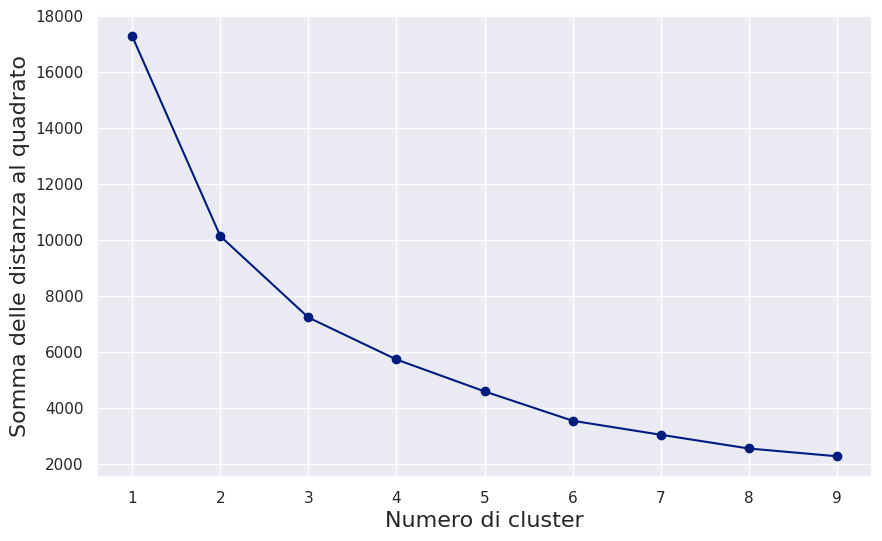

In [ ]:
plot_ssd_curve(X)

In [ ]:
def plot_clusters(model, data, cluster_names=None, axlabels=None, print_ssd=False):
    # Predice i cluster
    y_pred = model.predict(data)

    # Imposta le dimensioni della figura
    plt.figure(figsize=(10, 6))

    # Crea lo scatter plot dei dati con i cluster predetti
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_pred, s=100, palette='viridis')

    # Evidenzia i centri dei cluster
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', s=200, alpha=0.5, label='Centri dei cluster')


    if axlabels is not None:
        plt.xlabel(axlabels[0], fontsize=16)
        plt.ylabel(axlabels[1], fontsize=16)


    if print_ssd:
        plt.text(data[:, 0].max() - 10, data[:, 1].min() + 10, f"SSD={model.inertia_:.2f}", fontsize=12, color='red')

    # Gestione delle etichette della legenda
    if cluster_names is not None:
        legend_labels = {i: name for i, name in enumerate(cluster_names)}
        handles, _ = plt.gca().get_legend_handles_labels()
        plt.legend(handles, legend_labels.values(), title='Cluster', loc='upper right')

    # Mostra il plot
    plt.show()

In [ ]:
cluster_names = ["Clienti con pochi acquisti", "Clienti che optano, in rapporto, maggiormente per gli anticipi", "Clienti bilanciati", "Clienti che preferiscono usare liquidità", "Clienti che evitano gli anticipi"]

In [ ]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X) #standardizzazione dei dati

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10)
kmeans.fit(X_standardized) #addestramento kmeans su dati standardizzati

KMeans(n_clusters=5, n_init=10)

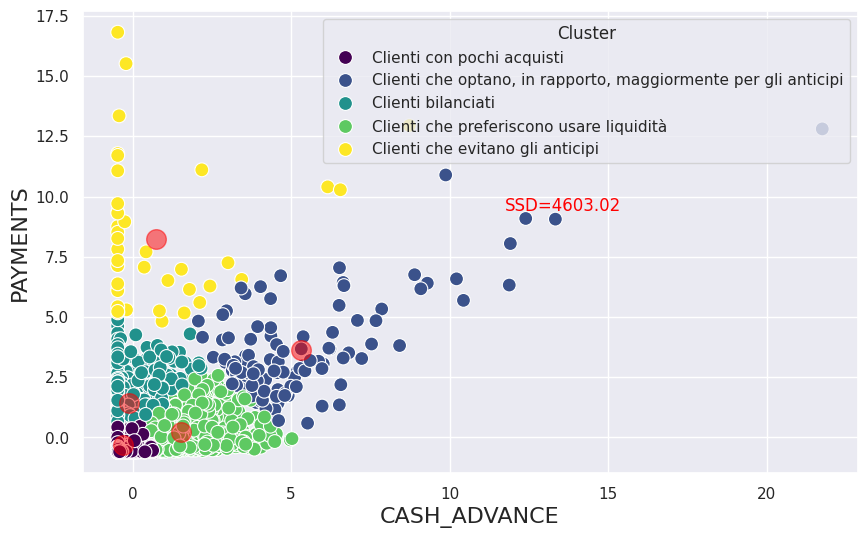

In [ ]:
plot_clusters(kmeans, X_standardized, cluster_names=cluster_names,axlabels=["CASH_ADVANCE", "PAYMENTS"], print_ssd=True) #scater su dati standardizzati precedentemente

In [ ]:
Y = df[["BALANCE", "PAYMENTS"]].values

ora accoppiamo le variabili balance e payments. questo accoppiamento potrebbe fornire informazioni su come i clienti gestiscono il loro saldo e effettuano i pagamenti. Ad esempio, potresti analizzare se i clienti con saldi più elevati tendono a fare pagamenti più alti o più bassi rispetto a quelli con saldi più bassi. Questo potrebbe aiutare a identificare i clienti che stanno accumulando debiti o che stanno gestendo responsabilmente il proprio saldo.

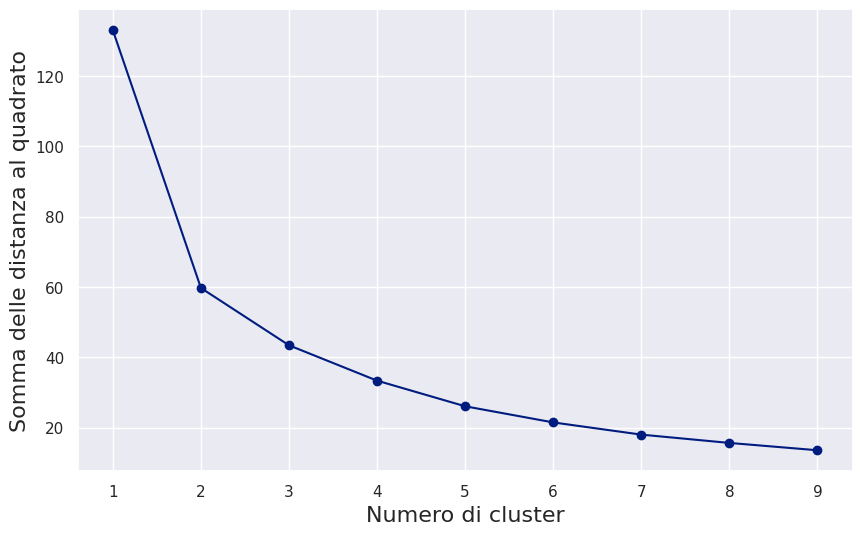

In [ ]:
plot_ssd_curve(Y)

In [ ]:
cluster_names_2 = ["Clienti bilanciati", "Clienti propensi ad usare carte di credito per pagamenti elevati", "Clienti con saldo elevato e pochi acquisti", "Clienti consapevoli"]

In [ ]:
Y_standardized = scaler.fit_transform(Y)

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++',n_init=10)
kmeans.fit(Y_standardized)

KMeans(n_clusters=4, n_init=10)

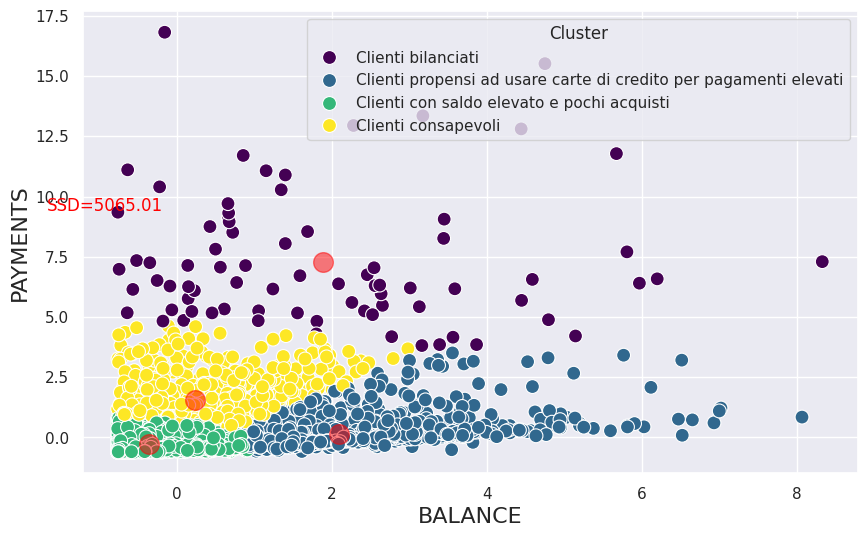

In [ ]:
plot_clusters(kmeans, Y_standardized, cluster_names=cluster_names_2, axlabels=["BALANCE","PAYMENTS"], print_ssd=True)

In [ ]:
S = df[["PURCHASES", "CREDIT_LIMIT"]].values

Questo accoppiamento potrebbe fornire informazioni su come i clienti utilizzano il proprio credito e effettuano acquisti. Ad esempio, possiamo esaminare se i clienti con limiti di credito più elevati tendono a fare acquisti più grandi o più piccoli rispetto a quelli con limiti di credito più bassi. Questo potrebbe aiutare a identificare i clienti che utilizzano appieno il proprio credito o che potrebbero avere bisogno di un aumento del limite di credito.

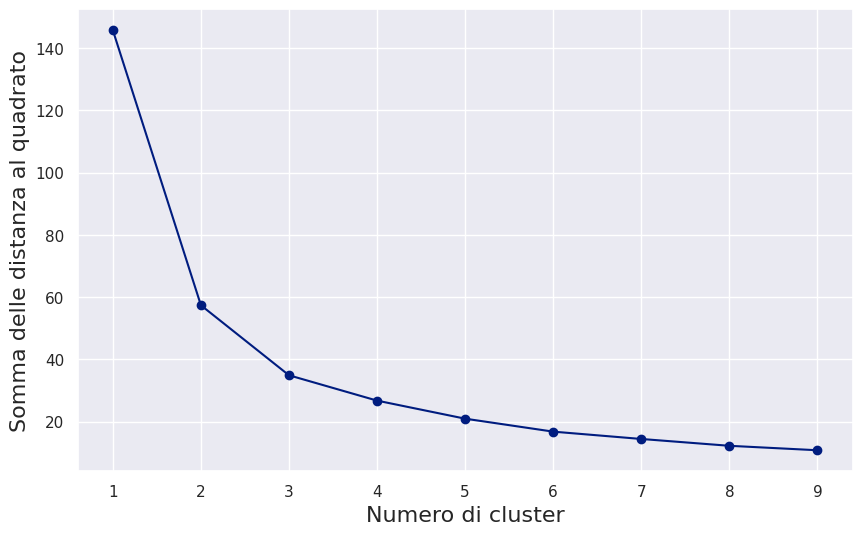

In [ ]:
plot_ssd_curve(S)

In [ ]:
cluster_names_3 = ["clienti con un saldo basso", "Clienti con un saldo alto", "Clienti che fanno molti acquisti rispetto al saldo e potrebebro necessitare di una carta di credito", "Clienti con saldo medio"]

In [ ]:
S_standardized = scaler.fit_transform(S)

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++',n_init=10)
kmeans.fit(S_standardized)

KMeans(n_clusters=4, n_init=10)

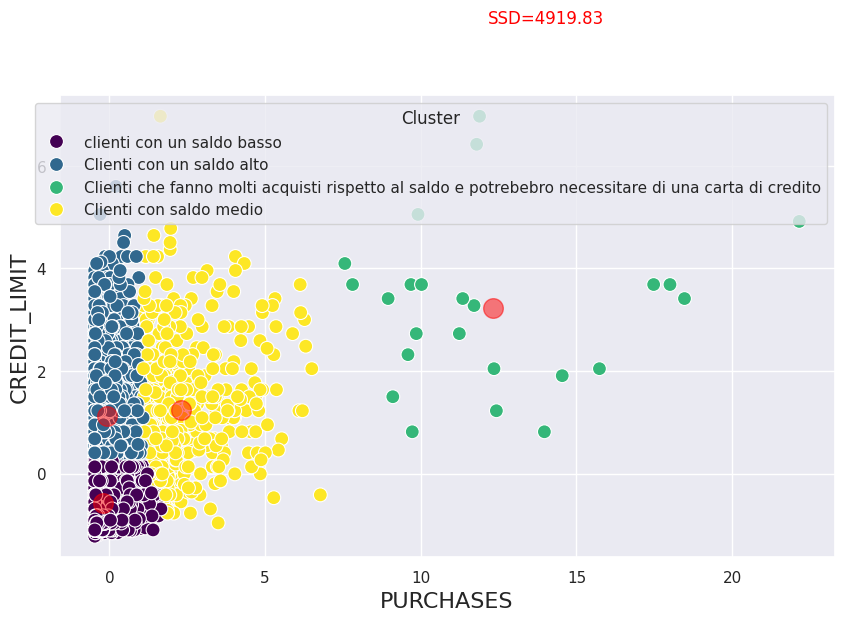

In [ ]:
plot_clusters(kmeans, S_standardized, cluster_names=cluster_names_3, axlabels=["PURCHASES","CREDIT_LIMIT"], print_ssd=True)

In [ ]:
L = df[["PAYMENTS", "MINIMUM_PAYMENTS"]].values

Questa coppia di variabili potrebbe rivelare il comportamento dei clienti riguardo ai pagamenti della carta di credito. Clienti che effettuano pagamenti regolari superiori al pagamento minimo potrebbero essere considerati responsabili dal punto di vista finanziario, mentre clienti che fanno solo il pagamento minimo potrebbero essere a rischio di indebitamento.

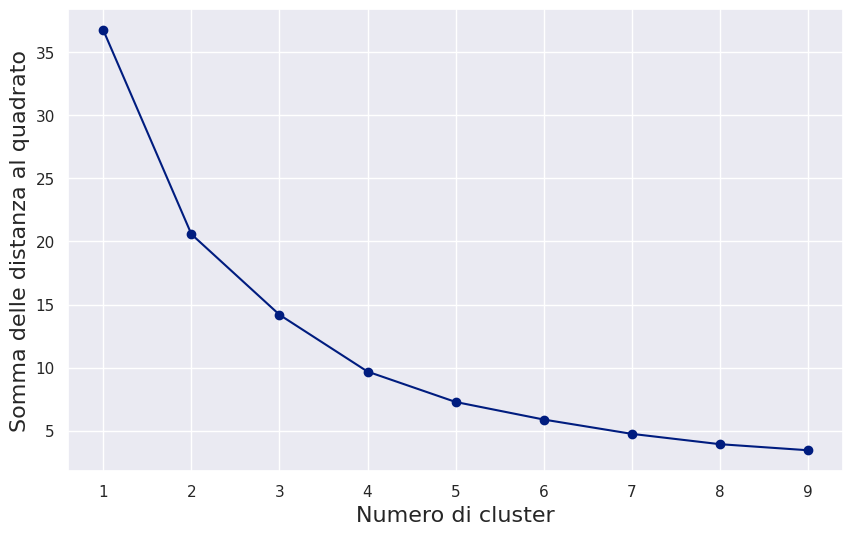

In [ ]:
plot_ssd_curve(L)

In [ ]:
cluster_names_5 = ["Cliente neutro", "Clienti a cui proporre la carta di credito", "Clienti con pochi acquisti"]

In [ ]:
L_standardized = scaler.fit_transform(L)

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++',n_init=10)
kmeans.fit(L_standardized)

KMeans(n_clusters=3, n_init=10)

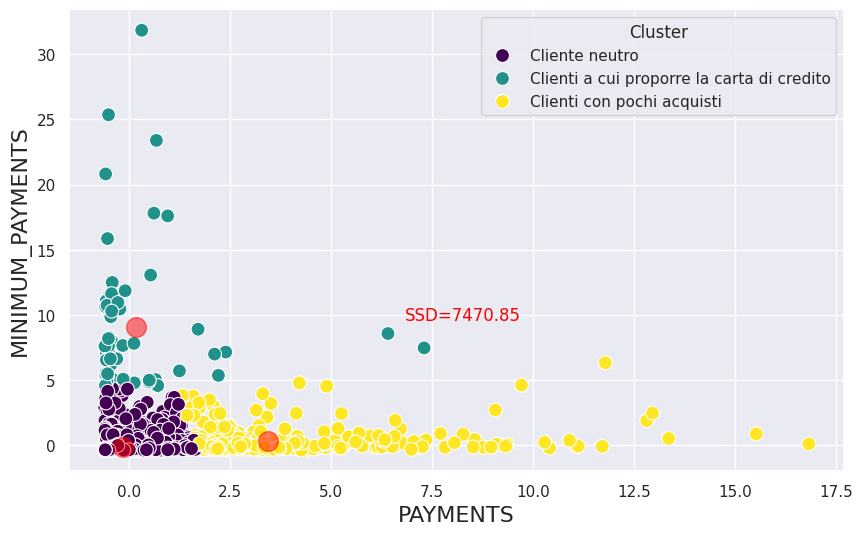

In [ ]:
plot_clusters(kmeans, L_standardized, cluster_names=cluster_names_5, axlabels=["PAYMENTS", "MINIMUM_PAYMENTS"], print_ssd=True)

In [ ]:
Z = df[[ "PURCHASES", "CASH_ADVANCE", "PAYMENTS"]].values

Analizzando queste tre variabili insieme, abbiamo una visione più completa dei modelli di spesa, dell'uso degli anticipi in contanti e della gestione dei pagamenti dei clienti. verrano identificati cluster di clienti con diversi comportamenti finanziari, come ad esempio clienti che fanno molti acquisti ma fanno pochi pagamenti, clienti che utilizzano spesso gli anticipi in contanti, o clienti che gestiscono responsabilmente i loro pagamenti e il loro saldo.

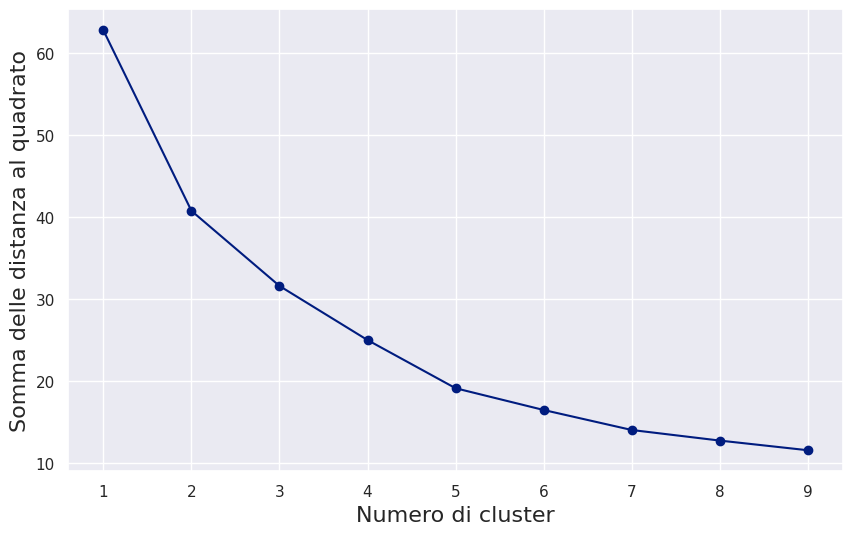

In [ ]:
plot_ssd_curve(Z)

In [ ]:
from mpl_toolkits import mplot3d

def plot_clusters3d(model, data, axlabels=None):

  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data)

  fig = plt.figure(figsize=(16,14))
  y_pred = model.predict(scaled_data)

  ax = plt.axes(projection ="3d")
  ax.scatter3D(data[:,0], data[:,1], data[:,2], edgecolors= "black", c=y_pred)
  ax.scatter3D(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], color="red", s=100)

  if axlabels is not None:
      ax.set_xlabel(axlabels[0])
      ax.set_ylabel(axlabels[1])
      ax.set_zlabel(axlabels[2])

      ax.tick_params(axis='x', which='both', labelsize=8)
      ax.tick_params(axis='y', which='both', labelsize=8)
      ax.tick_params(axis='z', which='both', labelsize=8)

  plt.show()


60074259452.09764


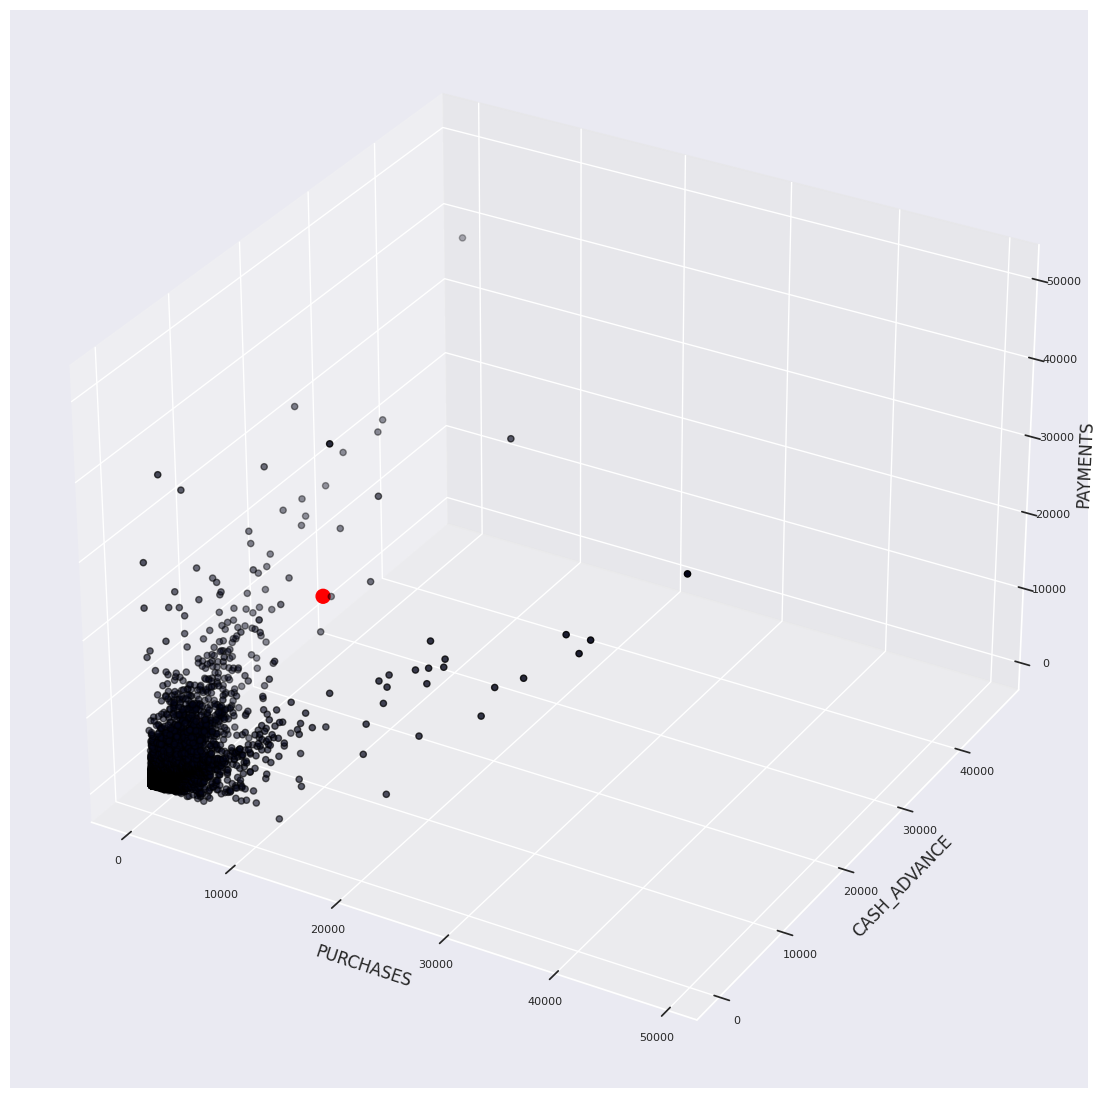

In [ ]:
%matplotlib inline
kmeans = KMeans(n_clusters=4, init = 'k-means++',n_init=10)
kmeans.fit(Z)
print(kmeans.inertia_)
plot_clusters3d(kmeans, Z, axlabels=["PURCHASES","CASH_ADVANCE","PAYMENTS"])

In [ ]:
F = df[[ "PURCHASES", "PURCHASES_FREQUENCY", "CREDIT_LIMIT"]].values

relazionando queste tre variabili possiamo vedere il volume degli acquisti, legato alla frequenza degli stessi rapportatti al limite della carta di credito. dunque i clienti con un alto limite di credito e un alto volume di acquisti potrebbero essere considerati clienti ad alto valore, che utilizzano attivamente la carta di credito per effettuare acquisti regolari e significativi mentre i clienti con un alto limite di credito ma una bassa frequenza di acquisti potrebbero essere considerati potenziali candidati per essere incoraggiati ad utilizzare la carta di credito più frequentemente, ad esempio attraverso promozioni o offerte personalizzate.

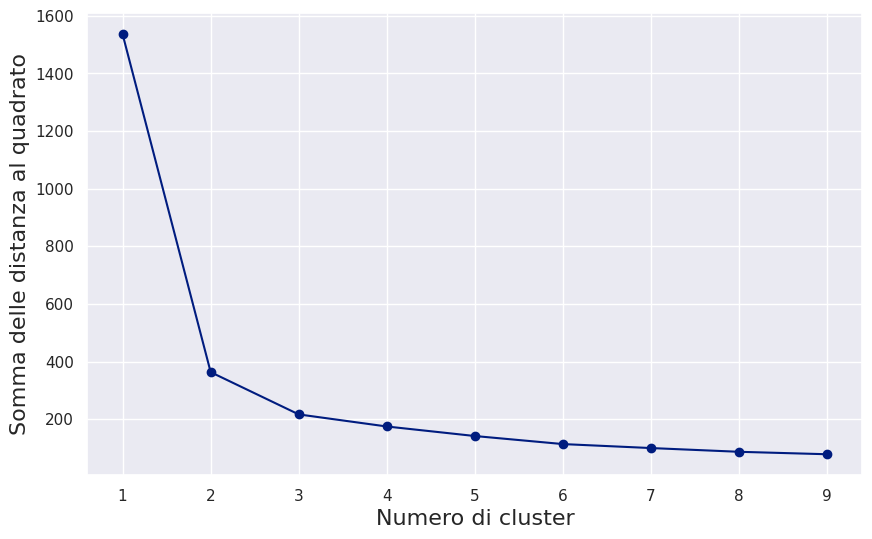

In [ ]:
plot_ssd_curve(F)

38272297327.1543


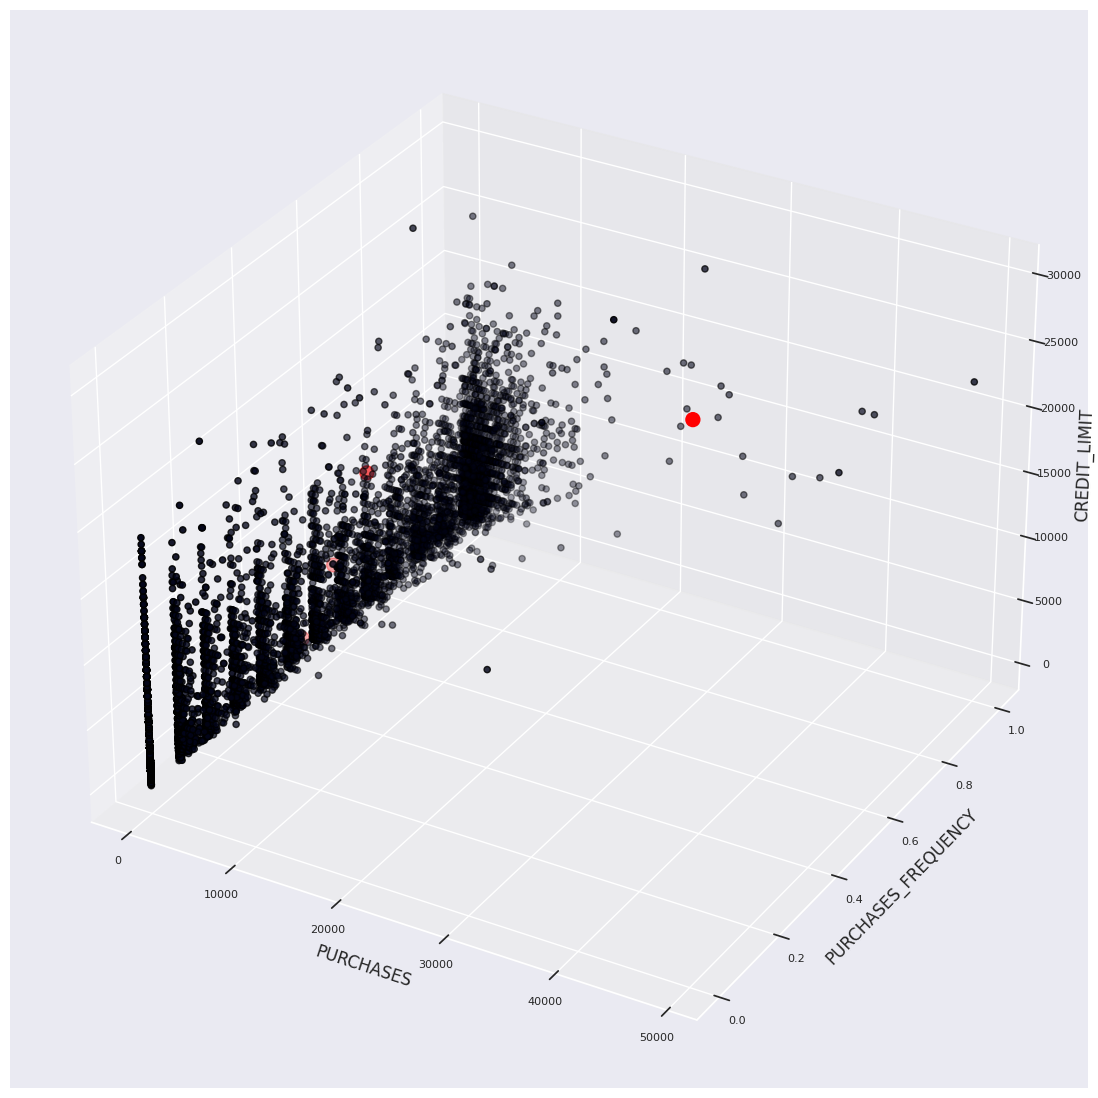

In [ ]:
%matplotlib inline
kmeans = KMeans(n_clusters=4, init = 'k-means++',n_init=10)
kmeans.fit(F)
print(kmeans.inertia_)
plot_clusters3d(kmeans, F, axlabels=["PURCHASES", "PURCHASES_FREQUENCY", "CREDIT_LIMIT"])